In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

from sklearn.datasets import load_boston

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')

warnings.filterwarnings("ignore")

# 1. 상관계수

두 변량 X, Y 사이의 상관관계(선형관계)의 정도를 나타내는 수치(계수)

- 확률변수의 상관계수
$$\rho = \dfrac{Cov(X,Y)}{\sqrt{V(X)}\sqrt{V(Y)}}$$


- 표본 상관계수
$$
r_{xy} = \dfrac{S_{xy}}{\sqrt{S_{xx}}\sqrt{S_{yy}}} 
= \dfrac{ \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})} {\sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2} \sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}
$$

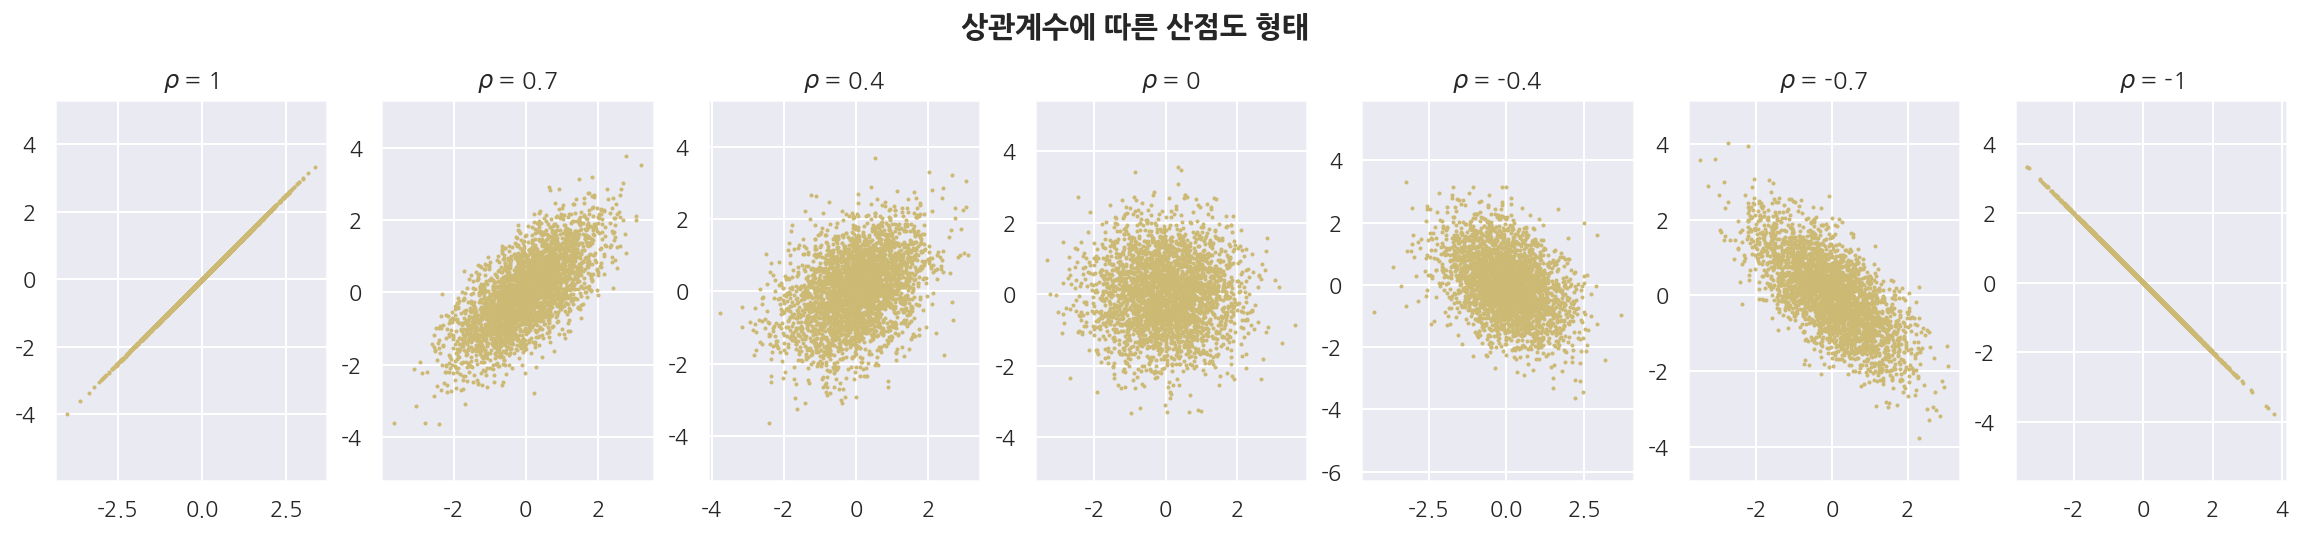

In [3]:
np.random.seed(1017)

corrs = [1, 0.7, 0.4, 0, -0.4, -0.7, -1]

plt.figure(figsize=(20, 3.5))

for i, r in enumerate(corrs):
    m = [0,0]
    cov = [[1, r],
           [r, 1]]
    
    x, y = np.random.multivariate_normal(m, cov, 3000).T
    
    plt.subplot(1, len(corrs), i + 1)
    plt.plot(x, y, 'yo', ms=1)
    plt.axis('equal')
    #plt.xticks([])
    #plt.yticks([])
    plt.title(f"$\\rho$ = {r}")

plt.suptitle("상관계수에 따른 산점도 형태", weight="bold", y=1.05)

plt.show()

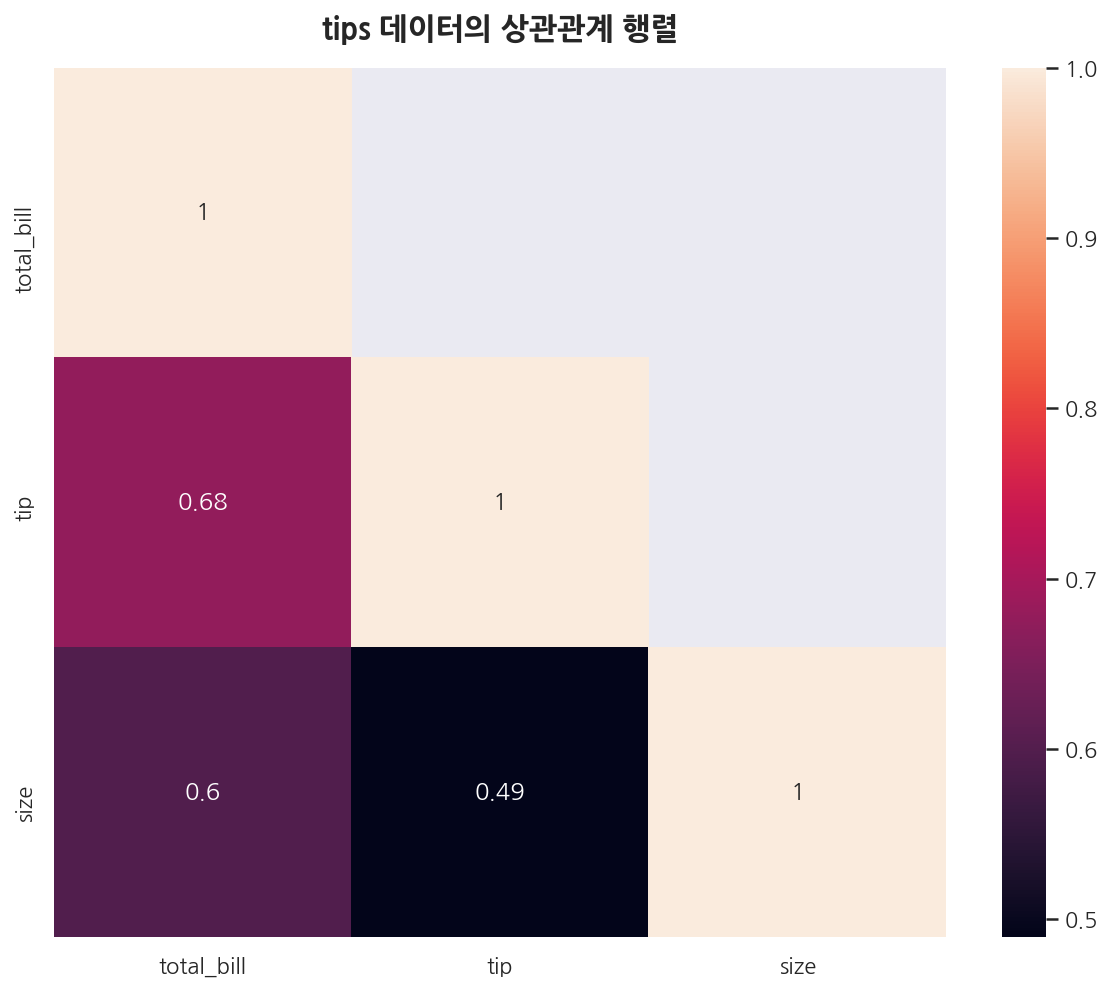

In [4]:
tips = sns.load_dataset("tips")
corr_matrix = tips.corr() # 상관계수 Matrix

fig = plt.figure(figsize= (10,8))

# 상관계수가 중복되지 않고 나오게
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(corr_matrix, 
            annot=True, 
            mask = mask)

plt.title("tips 데이터의 상관관계 행렬", weight="bold", fontsize=15, y=1.02)
plt.show()

# 2. 회귀분석

## 2.1 단순선형회귀

$Y = \beta_{0} + \beta_{1}X + \epsilon$

In [5]:
# 보스턴 집값 데이터 불러오기
boston = load_boston()
# print(boston.DESCR)

x_data = pd.DataFrame(boston.data, columns = boston.feature_names)
y_data = pd.DataFrame(boston.target, columns = ["MEDV"])

data = pd.concat([x_data, y_data], axis = 1)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
# beta_0 값 추가해주기
data = sm.add_constant(data)

# 단순선형회귀
fit1 = sm.OLS.from_formula(formula = "MEDV ~ AGE", data = data).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     83.48
Date:                Wed, 12 May 2021   Prob (F-statistic):           1.57e-18
Time:                        23:38:51   Log-Likelihood:                -1801.5
No. Observations:                 506   AIC:                             3607.
Df Residuals:                     504   BIC:                             3615.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.9787      0.999     31.006      0.0

- $\beta_{1}, \ \beta_{0}$ 검정결과 모두 유의하며 모형 역시 단순회귀이므로 같은 결과로 유의하다.


- 하지만 결정계수는 0.142로 매우 낮아 추정회귀식에 의해 설명되는 MEDV 변동은 14.2% 정도임을 알 수 있다.


- 추가적으로 단순회귀 일때 독립변수의 t통계량 제곱값은 F통계량으로 같은 결과이다.

**단순선형회귀에서 회귀계수 $\beta_{1}, \ \beta_{0}$**

- $\hat{\beta}_{1} = \dfrac{S_{xy}}{S_{xx}}, 
\quad \hat{\beta}_{0} = \bar{y} - \hat{\beta}_{1} \bar{x}$

In [7]:
Sxx = np.cov(data.AGE, data.MEDV)[0,0]
Sxy = np.cov(data.AGE, data.MEDV)[0,1]

x_bar = data.mean()["AGE"]
y_bar = data.mean()["MEDV"]

beta1 = Sxy / Sxx
beta0 = y_bar - beta1*x_bar

# fit1.params
print(f'베타1의 추정계수: {round(beta1, 4)}')
print(f'베타0의 추정계수: {round(beta0, 4)}')

베타1의 추정계수: -0.1232
베타0의 추정계수: 30.9787


**단순선형회귀에서 결정계수**

- $R^{2} = r^{2} = \dfrac{S_{xy}^{2}}{S_{xx}S_{yy}}$

In [8]:
# fit1.rsquared
rho_square = round( data[["MEDV","AGE"]].corr().iloc[0,1]**2, 3)
print(f"상관계수의 제곱: {rho_square}")

상관계수의 제곱: 0.142


## 2.2 모형의 진단

### 2.2.1 자료의 선형성

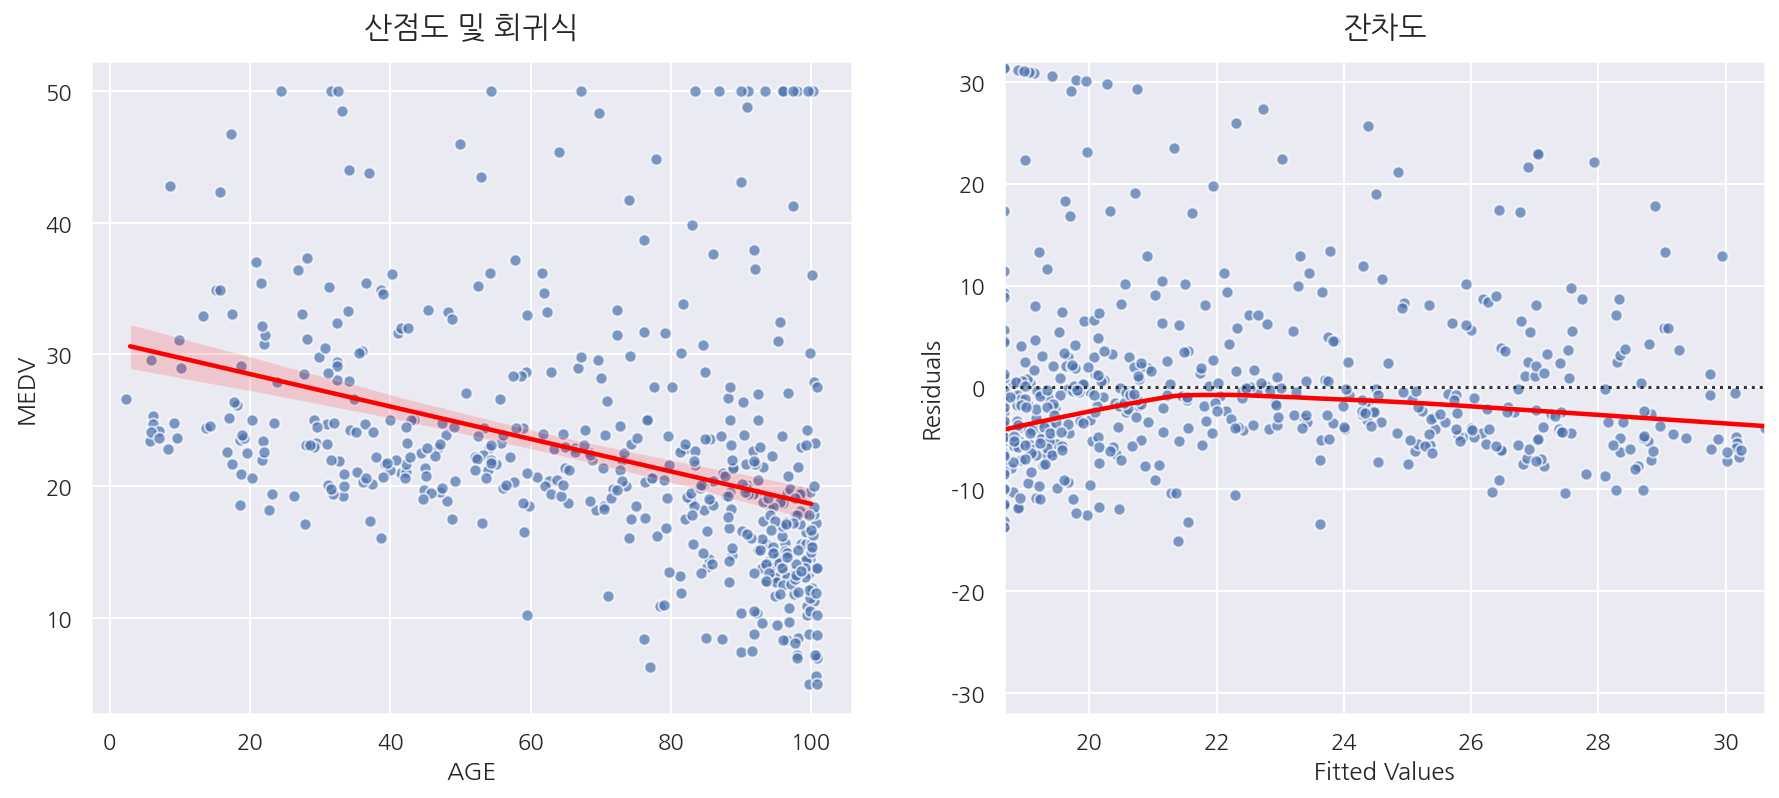

In [9]:
figure, axs = plt.subplots(1,2, figsize = (15,6))

# x,y 산점도 및 회귀식
sns.regplot(x = "AGE", y = "MEDV", 
            data = data, 
            scatter_kws = {'edgecolor':"white", "alpha":0.7}, 
            line_kws = {'color':"red"},    
            x_jitter = .9,
            ax = axs[0])

axs[0].set_title("산점도 및 회귀식", fontsize=15, y=1.02)

yhat = fit1.fittedvalues
temp = pd.concat( [ yhat, data["MEDV"] ], axis = 1)
temp.columns = [ "yhat", "MEDV" ]

sns.residplot(x = "yhat", y = "MEDV", 
              data = temp, 
              scatter_kws = {'edgecolor':"white", "alpha":0.7},
              lowess = True,
              line_kws = {"color":"red"},
              ax = axs[1])

axs[1].set_ylim(-32,32)
axs[1].set_title("잔차도", fontsize=15, y=1.02)
axs[1].set(xlabel= "Fitted Values", ylabel = "Residuals")

plt.show()

- 산점도로 보았을 때 어느정도의 선형성은 보이지만 AGE에 상관없이 MEDV가 큰 값들이 많이 보인다.


- 잔차도의 잔차추세선이 0을 기준으로 가까이 있을수록 선형성을 띈다고 볼 수 있다.

In [10]:
pearson_corr = stats.pearsonr(data["AGE"], data["MEDV"])

print('상관계수: {0:.2f}'.format(pearson_corr[0]))
print('p-value: {0:.3f}'.format(pearson_corr[1]))

상관계수: -0.38
p-value: 0.000


- 피어슨 상관분석 결과 상관계수는 -0.38로 음의 약한 관계로 나타났다.


- p-value는 0.05보다 작아 유의하게 나타났다.

### 2.2.1 오차의 정규성

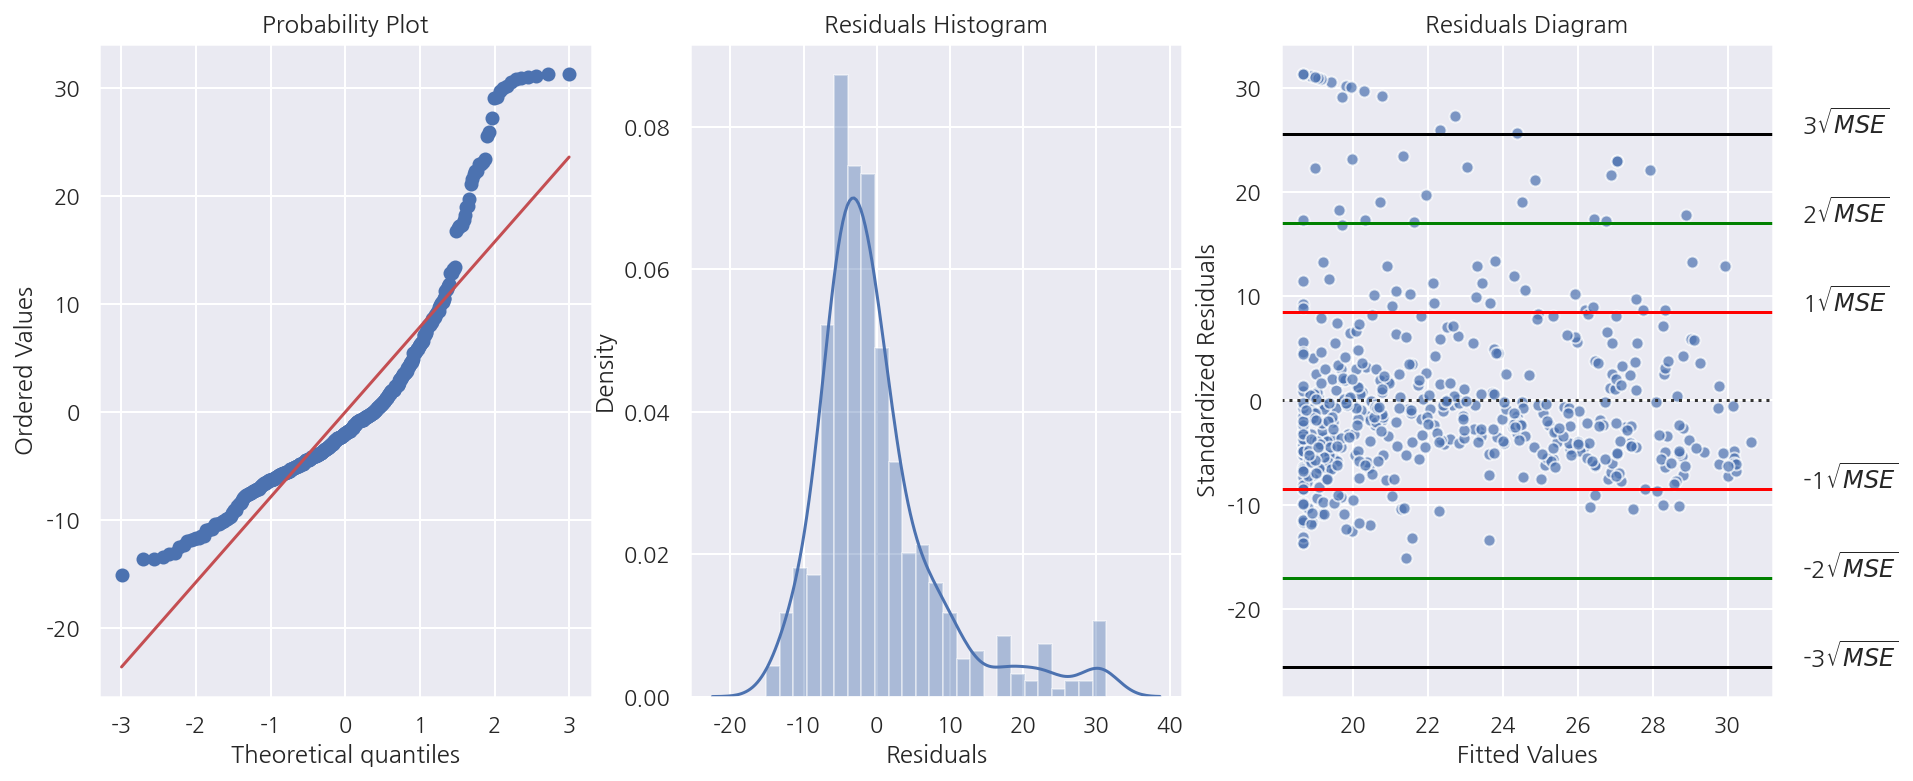

In [11]:
figure, axs = plt.subplots(1,3, figsize = (15,6))

# 잔차 Q-Q  plot
# sm.ProbPlot(fit1.resid).qqplot(line="s",ax=axs[0])
stats.probplot(fit1.resid, dist='norm', fit=True, plot=axs[0])

# 잔차의 히스토그램
sns.distplot(x = fit1.resid , ax = axs[1])
axs[1].set_xlabel("Residuals")
axs[1].set_title("Residuals Histogram")

# 잔차도
sns.residplot(x = "yhat", y = "MEDV", 
              data = temp, 
              scatter_kws = {'edgecolor':"white", "alpha":0.7},
              line_kws = {"color":"red"},
              ax = axs[2])

MSE_sq = np.sqrt(fit1.mse_resid)


for i, c in enumerate(["red", "green", "black"]):
    axs[2].axhline( (i+1) * MSE_sq, color = c)
    axs[2].axhline( -(i+1) * MSE_sq, color = c)
    
    axs[2].text(32, (i+1) * MSE_sq, f"{i+1}"r'${}\sqrt{MSE}$')
    axs[2].text(32, -(i+1) * MSE_sq, f"-{i+1}"r'${}\sqrt{MSE}$')

axs[2].set_xlabel("Fitted Values")
axs[2].set_ylabel("Standardized Residuals")
axs[2].set_title("Residuals Diagram")


plt.show()

In [12]:
r1 = fit1.resid[ (fit1.resid > -MSE_sq) & (fit1.resid < MSE_sq)].count() / fit1.resid.count() * 100
r2 = fit1.resid[ (fit1.resid > -2*MSE_sq) & (fit1.resid < 2*MSE_sq)].count() / fit1.resid.count() * 100
r3 = fit1.resid[ (fit1.resid > -3*MSE_sq) & (fit1.resid < 3*MSE_sq)].count() / fit1.resid.count() * 100

print(f"루트 1MSE 구간에 포함된 잔차 비율: {r1:1.2f}%")
print(f"루트 2MSE 구간에 포함된 잔차 비율: {r2:1.2f}%")
print(f"루트 3MSE 구간에 포함된 잔차 비율: {r3:1.2f}%")

루트 1MSE 구간에 포함된 잔차 비율: 80.24%
루트 2MSE 구간에 포함된 잔차 비율: 93.28%
루트 3MSE 구간에 포함된 잔차 비율: 97.04%


- 잔차 Q-Q Plot을 보았을때 45$^\circ$를 벗어나는 케이스가 많다.


- 잔차 히스토그램에선 잔차가 큰 값들이 다수 보여 오른쪽으로 꼬리가 생겨 정규분포로 보기 어렵다.


- 잔차가 정규분포를 따른다면 대략적으로 

    $\pm\sqrt{MSE}$ 안에 전체 잔차의 68%,
    
    $\pm2\sqrt{MSE}$ 안에 전체 잔차의 95%,
    
    $\pm3\sqrt{MSE}$ 안에 전체 잔차의 99%가 포함된다.

    어느 정도 만족을 하지만 역시 잔차가 큰 값이 많다는 것이 확인된다.

In [13]:
# 정규성 검정
omni_result = sm.stats.omni_normtest(fit1.resid)

print('statistic: {0:.3f}'.format(omni_result.statistic))
print('p-value: {0:.3f}'.format(omni_result.pvalue))

# Shapiro-Wilks test
#std_resid = fit1.resid/np.sqrt(fit1.mse_resid)
#shapiro_result = stats.shapiro(std_resid)

statistic: 170.034
p-value: 0.000


- p-vlaue가 0.05보다 작아 정규성을 만족한다고 볼 수 없다.


- 이는 회귀분석 summary에서도 확인 가능하다.

### 2.2.2 오차의 등분산성

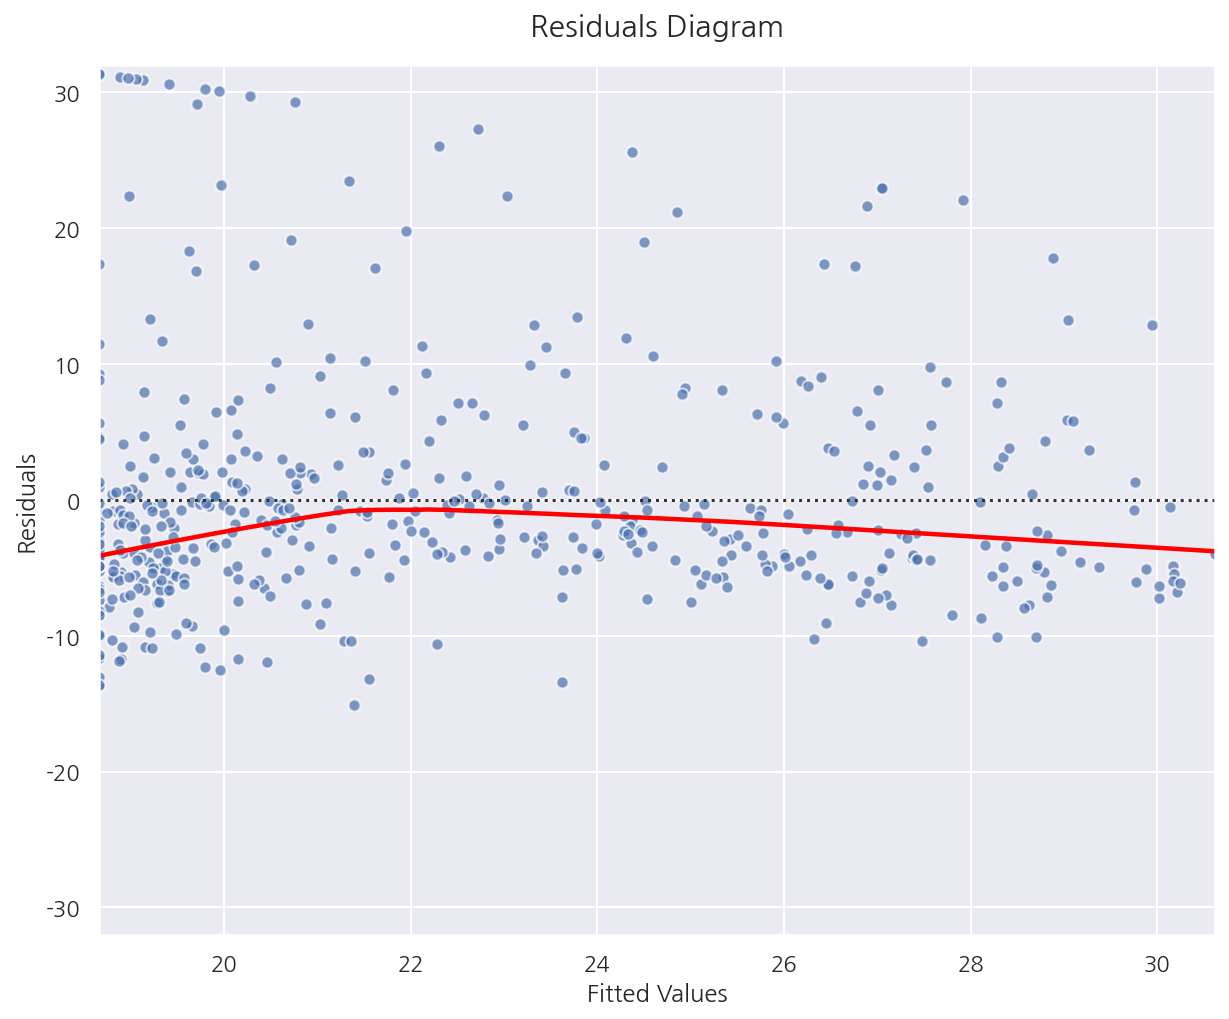

In [14]:
fig = plt.figure(figsize= (10,8))

p = sns.residplot(x = "yhat", y = "MEDV", 
                  data = temp, 
                  scatter_kws = {'edgecolor':"white", "alpha":0.7},
                  lowess = True,
                  line_kws = {"color":"red"})

p.set_ylim(-32,32)
p.set_title("Residuals Diagram", fontsize=15, y=1.02)
p.set(xlabel= "Fitted Values", ylabel = "Residuals")

plt.show()

- 등분산성이 만족된다면 Fitted Values(혹은 독립변수)의 값과 상관없이 같은 퍼짐 정도를 가져야한다. 

    즉, Fitted Values값에 상관없이 랜덤하게 분포되어 있어야 한다.
    

- 현재 잔차도로 확인하였을 때는 랜덤하게 분포되어 있는 것으로 보이며 등분산성을 만족하는 것으로 판단된다.

### 2.2.2 오차의 독립성

Durbin-Watson 검정통계량

- 0에 가까울수록 잔차들은 양의 자기상관을 가지며, 


- 2에 가까울수록 자기상관이 없어지며, 


- 2보다 크고 4에 가까워질수록 잔차들은 음의 자기상관을 갖는다. 


- 일반적으로 1.5 ~ 2.5사이 값이면 자기상관관계가 없어 독립이라고 판단한다.

자기상관관계가 있으면 MSE는 오차분산을 과소 추정하게 되어 t값, F값, 결정계수 값이 크게 나와 귀무가설을 기각하게 되어

실제로 유의미하지 않은 결과를 유의미한 결과로 왜곡하게 된다.

In [15]:
print(f"D-W 통계량: {round(durbin_watson(fit1.resid),3)}")

D-W 통계량: 0.613


- D-W 통계량이 0에 가까워 양의 자기상관관계가 있다고 판단된다.


- 이는 회귀분석 summary에서도 확인 가능하다.

추후 분산분석 테이블, 이상값, 적합결여검정, 중회귀 등